In [1]:
# import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [9]:
# set the working directory
import os
os.chdir(r'C:\Users\Admin\Videos\S5\deep learning\Deep Learning Application for Earth Observation\[TutsNode.net] - Deep Learning Application for Earth Observation\7. Image segmentation (Binary class)\archive (1)')
train_x = sorted(glob.glob('train/*_image.tif'))
train_y = sorted(glob.glob('train/*_label.tif'))
test_x = sorted(glob.glob('test/*_image.tif'))
test_y = sorted(glob.glob('test/*_label.tif'))

print(len(train_x), len(test_x))

70 30


In [10]:
# converting training image to numpy array
train_xx = np.zeros((70, 128, 128, 3))
train_yy = np.zeros((70, 128, 128, 1))
for i, (img, mask) in enumerate(zip(train_x, train_y)):
  # if i == 1:
  #   break
  
  img = Image.open(img)
  np_img = np.array(img)
  train_xx[i] = np_img 

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  train_yy[i] = np_mask 

In [11]:
# converting training image to numpy array
test_xx = np.zeros((30, 128, 128, 3))
test_yy = np.zeros((30, 128, 128, 1))
for i, (img, mask) in enumerate(zip(test_x, test_y)):
    
  img = Image.open(img)
  np_img = np.array(img)
  test_xx[i] = np_img 

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  test_yy[i] = np_mask 

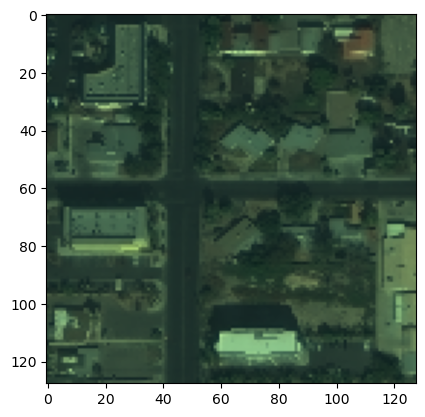

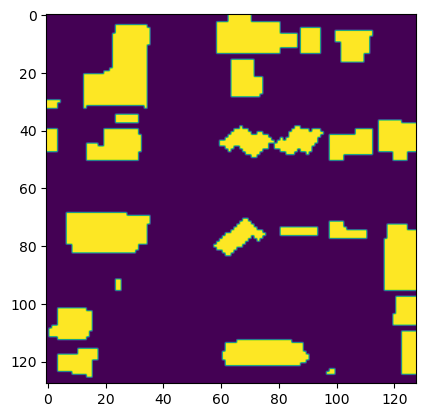

In [14]:
# Let's plot a sample input RGB image and output image with buildings

plt.imshow(train_xx[15, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[15, :, :, 0].astype('uint8'))
plt.show()

In [15]:
np.save('train_xx.npy', train_xx)
np.save('train_yy.npy', train_yy)
np.save("test_xx.npy", test_xx)
np.save("test_yy.npy", test_yy)

In [16]:
x_in = Input(shape=(128, 128, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
# use sigmoid activation here because output values are either 0 or 1

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [17]:
# training model
history = model.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=100, batch_size=10, verbose=1)

Epoch 1/100
7/7 [==============================] - 8s 757ms/step - loss: 0.1929 - val_loss: 0.1476
Epoch 2/100
7/7 [==============================] - 5s 686ms/step - loss: 0.1569 - val_loss: 0.1281
Epoch 3/100
7/7 [==============================] - 5s 675ms/step - loss: 0.1448 - val_loss: 0.1184
Epoch 4/100
7/7 [==============================] - 5s 672ms/step - loss: 0.1414 - val_loss: 0.1234
Epoch 5/100
7/7 [==============================] - 4s 638ms/step - loss: 0.1393 - val_loss: 0.1170
Epoch 6/100
7/7 [==============================] - 5s 651ms/step - loss: 0.1360 - val_loss: 0.1226
Epoch 7/100
7/7 [==============================] - 5s 691ms/step - loss: 0.1334 - val_loss: 0.1163
Epoch 8/100
7/7 [==============================] - 5s 650ms/step - loss: 0.1342 - val_loss: 0.1209
Epoch 9/100
7/7 [==============================] - 5s 675ms/step - loss: 0.1298 - val_loss: 0.1122
Epoch 10/100
7/7 [==============================] - 5s 666ms/step - loss: 0.1290 - val_loss: 0.1205
Epoch 11/

(30, 128, 128, 1)


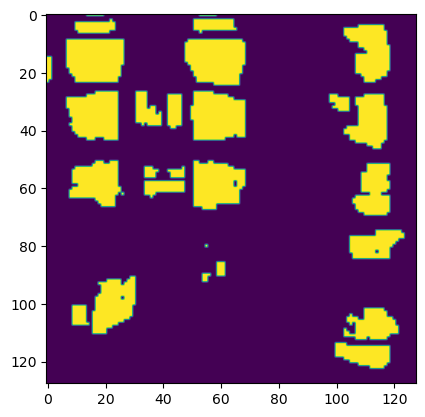

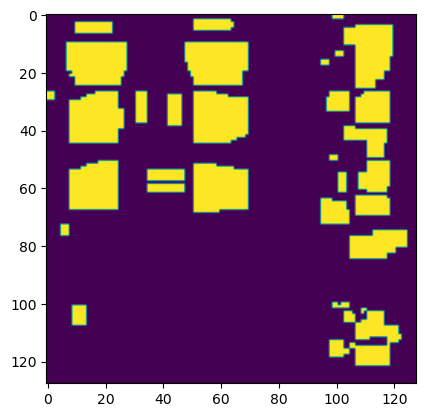

In [18]:
threshold = 0.5

# prediction of the output
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

#let's comare random predicted and actial y values 
plt.imshow(pred_test[10, :, :, 0])
plt.show()
plt.imshow(test_yy[10,:,:,0])
plt.show()